In [414]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import List, Dict
from sklearn import linear_model

In [446]:
class timeSeries():
    def __init__(self, df: pd.DataFrame, countries: List[str], start: str, end: str):
        df.dateRep = pd.to_datetime(df.dateRep, format='%d/%m/%Y')
        self.start = start
        self.end = end
        self.rawData = df
        self.allCountries = df.countriesAndTerritories.unique()
        self.processedData = self.extract_countries_and_time(countries, start, end)


    def extract_countries_and_time(self, countries: List[str], start: str, end: str) -> pd.DataFrame:
        """
        :param str df_path: default = path
        :param list<str> countries
        :param str start: yyyy-mm-dd
        :param str end: yyyy-mm-dd 
        """
        df = self.rawData
        df = df[["dateRep", "day", "month", "year", "cases", "countriesAndTerritories"]]
        df = df[df.countriesAndTerritories.isin(countries)]
        df = df.sort_values(["year", "month","day"])
        df["cumCases"] = df.groupby(["countriesAndTerritories"])["cases"].cumsum(axis=0)


        if (start == "start") & (end == "end"):
            output_df = df
        elif (start == "start"):
            output_df = df[df.dateRep <= end]
        elif (end == "end"):
            output_df = df[df.dateRep >= start]
        else:
            output_df = df[(start <= df.dateRep) & (df.dateRep <= end)]

        return output_df

    def plot(self) -> pd.DataFrame:
        df = self.processedData
        groups = df.groupby("countriesAndTerritories")

        fig, ax = plt.subplots(figsize = (10,5))
        ax.margins(0.05)

        for name, group in groups:
            ax.plot(group.dateRep, group.cumCases, label=name)

        ax.legend()
        plt.show()

    def extract_country(self, country: str):
        df = self.processedData
        df = df.reset_index(drop = True)
        df = df[df.countriesAndTerritories == country]
        df["t"] = list(range(len(df)))
        df = df.reset_index(drop = True)
        return df[["dateRep", "t", "cumCases"]]

    def beta(self, country_name: str):
        country = self.extract_country(country_name)
        I_0 = np.double(country.loc[country["t"] == 0, "cumCases"])
        t = np.array(country.loc[country["t"] > 0, "t"]).reshape(-1, 1)
        cumCases = np.array(country.loc[country["t"] > 0, "cumCases"]).reshape(-1, 1)

        reg = linear_model.LinearRegression()
        reg.fit(t, np.log(cumCases) - np.log(I_0))
        est_beta = np.double(reg.coef_).round(4)

        fig, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)

        prediction = I_0 * np.exp(est_beta * t)

        ax.set_title(f"Prediction vs. real data in {country_name}, time interval: {self.start} - {self.end}")
        ax.plot(country.t[1:],prediction, label="Predicted", color="red")
        ax.plot(country.t[1:],country.cumCases[1:], label="Real data", color="green")

        ax.legend()
        plt.show() 

        return est_beta
        

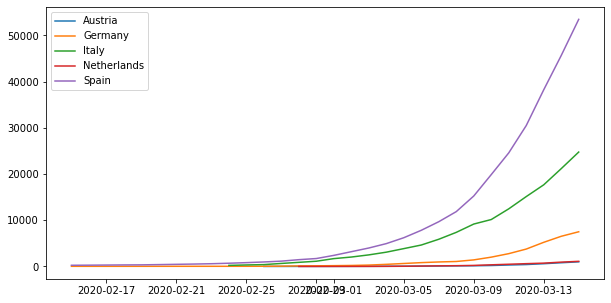

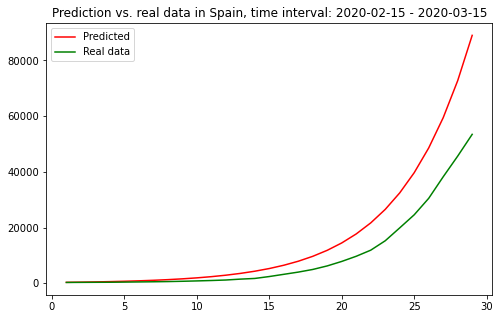

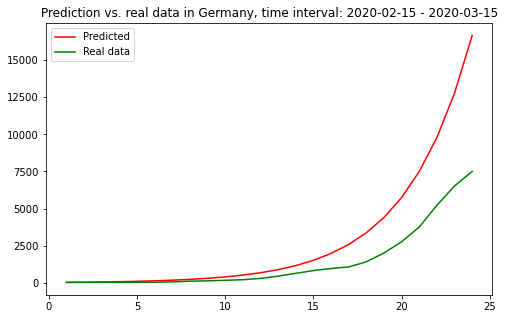

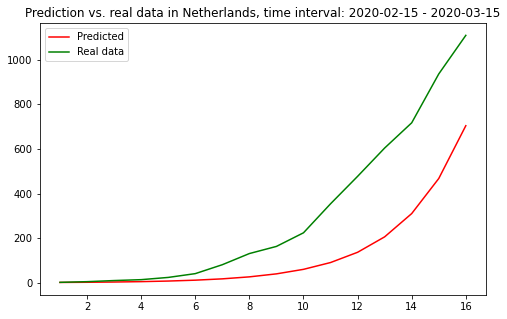

,dateRep,t,cumCases
0,2020-02-24,0,229.0
1,2020-02-25,1,322.0
2,2020-02-26,2,400.0
3,2020-02-27,3,650.0
4,2020-02-28,4,888.0
5,2020-02-29,5,1128.0
6,2020-03-01,6,1694.0
7,2020-03-02,7,2036.0
8,2020-03-03,8,2502.0
9,2020-03-04,9,3089.0


In [453]:
df = pd.read_csv("data/europe_timeseries.csv")
ts = timeSeries(df, ["Germany", "Italy", "Spain", "Austria", "Netherlands"], "2020-02-15", "2020-03-15")
ts.plot()
ts.beta("Spain")
ts.beta("Germany")
ts.beta("Netherlands")

ts.extract_country("Italy")


In [449]:
ts.allCountries

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden'], dtype=object)